In [1]:
import os
import configparser

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
from matplotlib.collections import PatchCollection

from matplotlib import font_manager
from bivariate_color_generator import *

In [2]:
#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), ".."))
config_file =  os.path.join(root, "config.cfg")

# geodata for shapefiles
config = configparser.ConfigParser()
config.read(config_file)
gdata_root = config["geodata"]["path"]

In [3]:
#font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
title_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Inter-Bold.otf')
subtitle_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Inter-SemiBold.otf')
label_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Inter-Medium.otf')

# Load data

In [4]:
#car ownership
cars = pd.read_excel("data\\TS045-2021-3.xlsx")
cars = cars.pivot(index=['Lower Tier Local Authorities Code', 'Lower Tier Local Authorities'],
                 columns='Car or van availability (5 categories) Code', values='Observation').reset_index()
cars["total_car_owners"] = cars[[ 1,2,3]].sum(axis=1)
cars["prop_car_owners"] = cars[[ 1,2,3]].sum(axis=1)/cars[[ 0, 1,2,3]].sum(axis=1)*100
cars = cars.rename(columns={'Lower Tier Local Authorities Code':"LA Code", 'Lower Tier Local Authorities': "LA Name"})
cars = cars[['LA Code', 'LA Name',  0, 'total_car_owners', 'prop_car_owners']]

In [5]:
#london shapefile
london = gpd.GeoDataFrame.from_file(os.path.join(gdata_root,"london-shapefiles\\London_Borough_Excluding_MHW.shp"))
london = london.to_crs('4326')

In [6]:
#cycling rates
cyc_any = pd.read_excel("data\\cw0302.xlsx", sheet_name="CW0302_Any_Purpose", skiprows=7)
cyc_leisure = pd.read_excel("data\\cw0302.xlsx", sheet_name="CW0302_Leisure", skiprows=7)
cyc_travel = pd.read_excel("data\\cw0302.xlsx", sheet_name="CW0302_Travel", skiprows=7)
cyc_all = pd.concat([cyc_any, cyc_leisure, cyc_travel])

# Car ownership vs cycling rate (any purpose)

In [7]:
#filter for 2021 and at least one a week
cycling = cyc_all[(cyc_all["Frequency"]=="At least once per week") & 
                  (cyc_all["Purpose"]=="Any")][["ONS Code", "Area name", "2021"]].rename(columns={"2021":"cycling_rate"})

In [8]:
# merge datasets
df = pd.merge(london, cycling, left_on="GSS_CODE", right_on="ONS Code", how="left")
df = pd.merge(df, cars, left_on="GSS_CODE", right_on="LA Code", how="left")

#create percentiles
df['car_percentiles'] = pd.qcut(df["prop_car_owners"], 10, labels=np.arange(10,110,10)).astype(int)
df['cyc_percentiles'] = pd.qcut(df["cycling_rate"], 10, labels=np.arange(10,110,10)).astype(int)
df['car_quartiles'] = pd.qcut(df["prop_car_owners"],  4, labels=np.arange(25,125,25)).astype(int)
df['cyc_quartiles'] = pd.qcut(df["cycling_rate"],  4, labels=np.arange(25,125,25)).astype(int)

In [9]:
#get colours
lb_color = '#d8d8d8' #lower bottom
tl_color = '#5ac8c8' #top left
lr_color = '#be64ac' #lower right
tr_color = '#3b4994' #top right
bounds = [25, 75, 100]
v1 = 'cyc_quartiles'
v2 = 'car_quartiles'

colorlist = get_colorlist(bounds, lb_color, tl_color, lr_color, tr_color)
df['color_bivariate'] = [get_bivariate_choropleth_color(v1, v2, bounds, colorlist) for v1,v2 
                          in zip(df[v1].values, df[v2].values)]

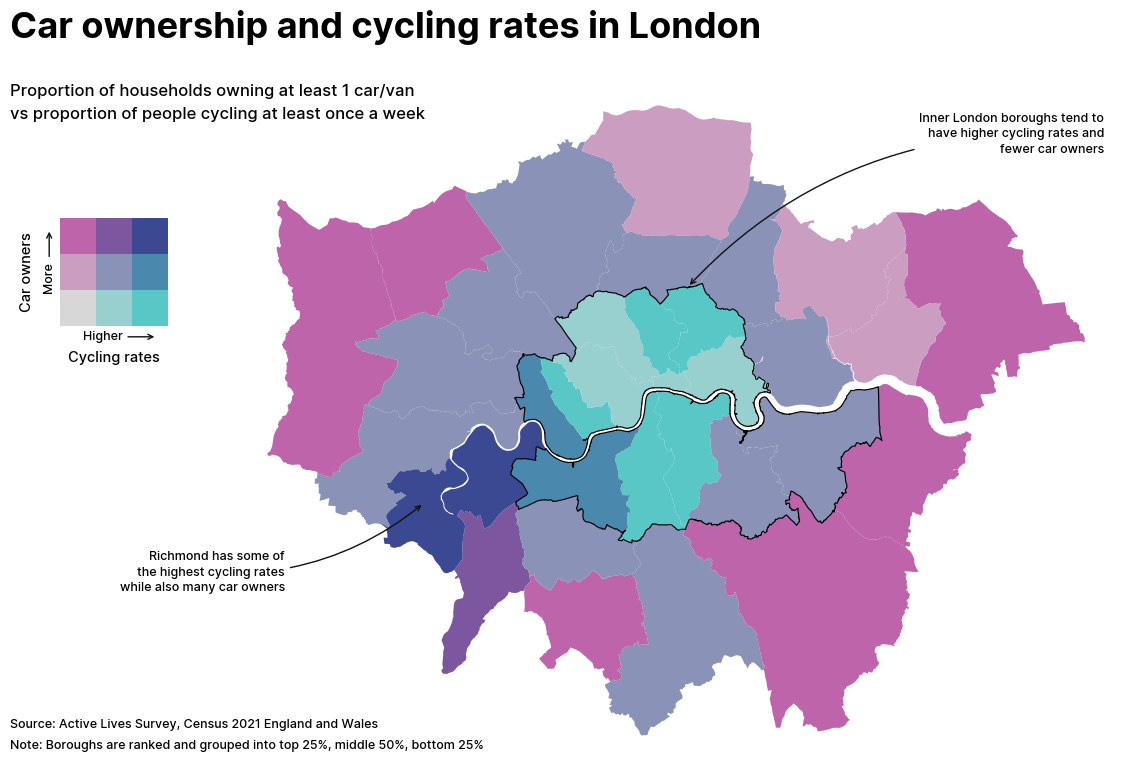

In [31]:
labels = {v2: "Car owners", v1: "Cycling rates"}

### plot map based on bivariate choropleth
fig, ax = plt.subplots(1,1, figsize=(13,9))

#plot bivariate values
gdf = df.to_crs(3857)
gdf.plot(ax=ax, color=gdf['color_bivariate'])
ax.axis("off")

#highlight inner London
inner = ['Camden','City of London', 'Greenwich','Hackney','Hammersmith and Fulham','Islington',
         'Kensington and Chelsea','Lambeth','Lewisham','Southwark','Tower Hamlets','Wandsworth','Westminster']
d = {'name': "inner", 'geometry': gdf[gdf["NAME"].isin(inner)].unary_union.boundary.simplify(3)  }
gdf_inner = gpd.GeoDataFrame(d, crs="EPSG:3857")
gdf_inner.plot(ax=ax,edgecolor="black", linewidth=0.85)

### annotation
kw = dict(arrowstyle="->", color="#111111")
y = gdf[gdf["NAME"]=="Richmond upon Thames"].centroid.y
x = gdf[gdf["NAME"]=="Richmond upon Thames"].centroid.x
ax.annotate('Richmond has some of\nthe highest cycling rates\nwhile also many car owners', 
            xy=(x-4000, y-1000), xycoords='data', xytext=(-100, -50), textcoords='offset points',linespacing=1.4 ,
                   fontsize=12, ha='right', va='center', annotation_clip=False, fontproperties=label_font,
                    arrowprops=dict(**kw, connectionstyle="arc3,rad=.2", clip_on=False))
y = gdf[gdf["NAME"]=="Islington"].bounds.maxy
x = gdf[gdf["NAME"]=="Islington"].bounds.maxx
ax.annotate('Inner London boroughs tend to\nhave higher cycling rates and\nfewer car owners', 
            xy=(x, y), xycoords='data', xytext=(+300, +110), textcoords='offset points',linespacing=1.4 ,
                   fontsize=12, ha='right', va='center', annotation_clip=False, fontproperties=label_font,
                    arrowprops=dict(**kw, connectionstyle="arc3,rad=.2", clip_on=False))

#### create legend
ax1 = fig.add_axes([0.02,0.6, 0.12,0.12], zorder=1)
ax1.set_aspect('equal', adjustable='box')
count = 0
xticks = [0]
yticks = [0]
for i, bound_v1 in enumerate(bounds):
    for j, bound_v2 in enumerate(bounds):
        percentileboxes = [Rectangle((i,j), 1, 1)]
        pc = PatchCollection(percentileboxes, facecolor=colorlist[count])
        count += 1
        ax1.add_collection(pc)
        if i == 0:
            yticks.append(bound_v2)
    xticks.append(bound_v1)   
ax1.set_xlim([0,len(bounds)])
ax1.set_ylim([0,len(bounds)])
ax1.annotate('Higher', xy=(2.7, -0.3), xycoords='data', xytext=(-25, 0), textcoords='offset points', fontsize=9, 
             ha='right', va='center', annotation_clip=False, fontproperties=label_font,
                    arrowprops=dict(**kw, connectionstyle="arc3,rad=.0", clip_on=False))
ax1.annotate('More', xy=(-0.3, 2.7), xycoords='data', xytext=(0, -35), textcoords='offset points', fontsize=9, 
             ha='center', va='center', annotation_clip=False, fontproperties=label_font, rotation=90,
                arrowprops=dict(**kw, connectionstyle="arc3,rad=.0", clip_on=False))
ax1.text(1.5,-1., labels[v1], ha="center", fontproperties=label_font,fontsize=10.5)
ax1.text(-1.1,1.5, labels[v2], va="center", rotation=90,fontproperties=label_font,fontsize=10.5)
ax1.set_xticks([])
ax1.set_yticks([])
for pos in ["top", "bottom", "left", "right"]:
    ax1.spines[pos].set_visible(False)

### Title and footer
plt.figtext(0.0, 0.92, "Car ownership and cycling rates in London", fontproperties= title_font, fontsize=26,  ha="left")
plt.figtext(0.0, 0.83, "Proportion of households owning at least 1 car/van\nvs proportion of people cycling at least once a week",
            linespacing=1.7,fontproperties=label_font, fontsize=12, ha="left", )
#plt.figtext(0.0, 0.8, "Data shown as top and bottom ranks.",
 #           linespacing=1.7,fontproperties=label_font, fontsize=12, ha="left", )
plt.figtext(0.0, 0.13, "Source: Active Lives Survey, Census 2021 England and Wales\nNote: Boroughs are ranked and grouped into top 25%, middle 50%, bottom 25%", 
            fontproperties=label_font, fontsize=9, ha="left", linespacing=2)




plt.savefig("cycling-vs-carowners-london-bivariate.png", dpi=300, bbox_inches='tight', pad_inches=0.25)

plt.show()

# Car ownership vs cycling rates (commuting)

In [27]:
#filter for 2021 and at least one a week
cycling = cyc_all[(cyc_all["Frequency"]=="At least once per week") & 
                  (cyc_all["Purpose"]=="Travel")][["ONS Code", "Area name", "2021"]].rename(columns={"2021":"cycling_rate"})

In [28]:
# merge datasets
df = pd.merge(london, cycling, left_on="GSS_CODE", right_on="ONS Code", how="left")
df = pd.merge(df, cars, left_on="GSS_CODE", right_on="LA Code", how="left")

#create percentiles
df['car_percentiles'] = pd.qcut(df["prop_car_owners"], 10, labels=np.arange(10,110,10)).astype(int)
df['cyc_percentiles'] = pd.qcut(df["cycling_rate"], 10, labels=np.arange(10,110,10)).astype(int)
df['car_quartiles'] = pd.qcut(df["prop_car_owners"],  4, labels=np.arange(25,125,25)).astype(int)
df['cyc_quartiles'] = pd.qcut(df["cycling_rate"],  4, labels=np.arange(25,125,25)).astype(int)

In [29]:
#get colours
lb_color = '#d8d8d8' #lower bottom
tl_color = '#5ac8c8' #top left
lr_color = '#be64ac' #lower right
tr_color = '#3b4994' #top right
bounds = [25, 75, 100]
v1 = 'cyc_quartiles'
v2 = 'car_quartiles'

colorlist = get_colorlist(bounds, lb_color, tl_color, lr_color, tr_color)
df['color_bivariate'] = [get_bivariate_choropleth_color(v1, v2, bounds, colorlist) for v1,v2 
                          in zip(df[v1].values, df[v2].values)]

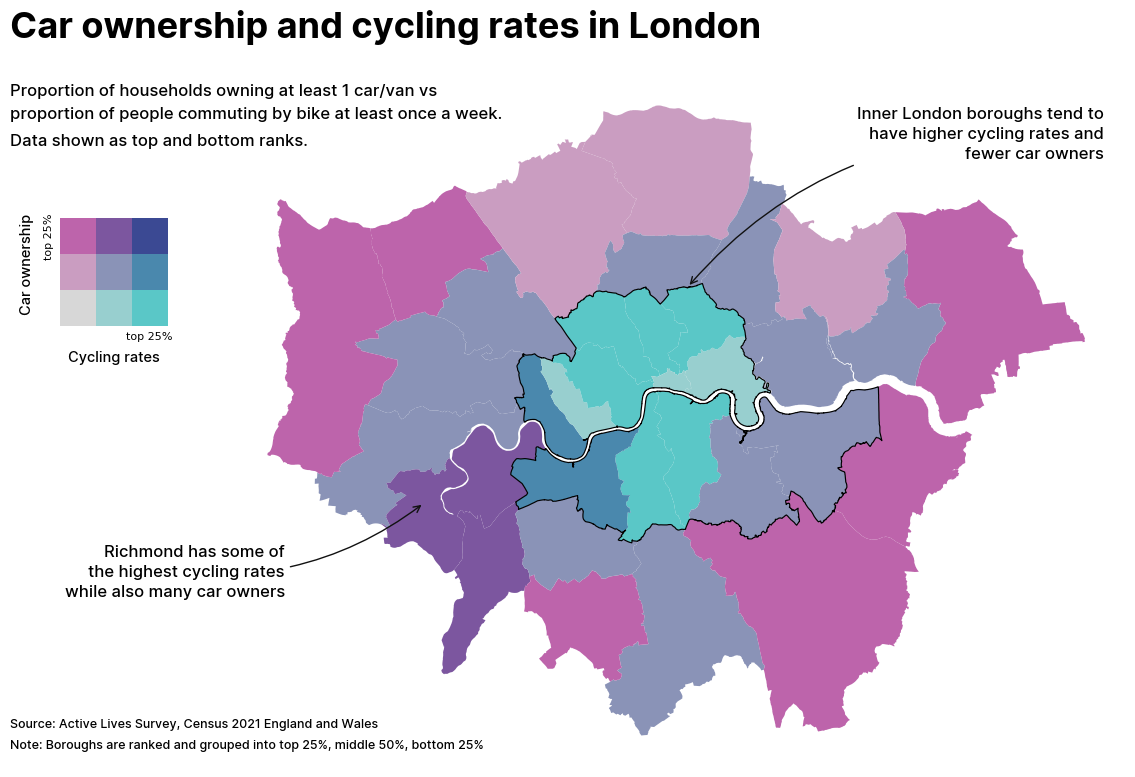

In [35]:
labels = {v2: "Car ownership", v1: "Cycling rates"}

### plot map based on bivariate choropleth
fig, ax = plt.subplots(1,1, figsize=(13,9))

#plot bivariate values
gdf = df.to_crs(3857)
gdf.plot(ax=ax, color=gdf['color_bivariate'])
ax.axis("off")

#highlight inner London
inner = ['Camden','City of London', 'Greenwich','Hackney','Hammersmith and Fulham','Islington',
         'Kensington and Chelsea','Lambeth','Lewisham','Southwark','Tower Hamlets','Wandsworth','Westminster']
d = {'name': "inner", 'geometry': gdf[gdf["NAME"].isin(inner)].unary_union.boundary.simplify(3)  }
gdf_inner = gpd.GeoDataFrame(d, crs="EPSG:3857")
gdf_inner.plot(ax=ax,edgecolor="black", linewidth=0.85)

#### create legend
ax1 = fig.add_axes([0.02,0.6, 0.12,0.12], zorder=1)
ax1.set_aspect('equal', adjustable='box')
count = 0
xticks = [0]
yticks = [0]
for i, bound_v1 in enumerate(bounds):
    for j, bound_v2 in enumerate(bounds):
        percentileboxes = [Rectangle((i,j), 1, 1)]
        pc = PatchCollection(percentileboxes, facecolor=colorlist[count])
        count += 1
        ax1.add_collection(pc)
        if i == 0:
            yticks.append(bound_v2)
    xticks.append(bound_v1)   
ax1.set_xlim([0,len(bounds)])
ax1.set_ylim([0,len(bounds)])
ax1.set_xlabel('                    top 25%', fontsize=8)
ax1.set_ylabel('                    top 25%', fontsize=8)
ax1.text(1.5,-1., labels[v1], ha="center", fontproperties=label_font,fontsize=10.5)
ax1.text(-1.1,1.7, labels[v2], va="center", rotation=90,fontproperties=label_font,fontsize=10.5)
ax1.set_xticks([])
ax1.set_yticks([])
for pos in ["top", "bottom", "left", "right"]:
    ax1.spines[pos].set_visible(False)

### Title and footer
plt.figtext(0.0, 0.92, "Car ownership and cycling rates in London", fontproperties= title_font, fontsize=26,  ha="left")
plt.figtext(0.0, 0.83, "Proportion of households owning at least 1 car/van vs\nproportion of people commuting by bike at least once a week.",
            linespacing=1.7,fontproperties=label_font, fontsize=12, ha="left", )
plt.figtext(0.0, 0.8, "Data shown as top and bottom ranks.",
            linespacing=1.7,fontproperties=label_font, fontsize=12, ha="left", )
plt.figtext(0.0, 0.13, "Source: Active Lives Survey, Census 2021 England and Wales\nNote: Boroughs are ranked and grouped into top 25%, middle 50%, bottom 25%", 
            fontproperties=label_font, fontsize=9, ha="left", linespacing=2)

### annotation
kw = dict(arrowstyle="->", color="#111111")
y = gdf[gdf["NAME"]=="Richmond upon Thames"].centroid.y
x = gdf[gdf["NAME"]=="Richmond upon Thames"].centroid.x
ax.annotate('Richmond has some of\nthe highest cycling rates\nwhile also many car owners', 
            xy=(x-4000, y-1000), xycoords='data', xytext=(-100, -50), textcoords='offset points',linespacing=1.4 ,
                   fontsize=12, ha='right', va='center', annotation_clip=False, fontproperties=label_font,
                    arrowprops=dict(**kw, connectionstyle="arc3,rad=.2", clip_on=False))
y = gdf[gdf["NAME"]=="Islington"].bounds.maxy
x = gdf[gdf["NAME"]=="Islington"].bounds.maxx
ax.annotate('Inner London boroughs tend to\nhave higher cycling rates and\nfewer car owners', 
            xy=(x, y), xycoords='data', xytext=(+300, +110), textcoords='offset points',linespacing=1.4 ,
                   fontsize=12, ha='right', va='center', annotation_clip=False, fontproperties=label_font,
                    arrowprops=dict(**kw, connectionstyle="arc3,rad=.2", clip_on=False))


plt.savefig("cycling-vs-carowners-london-travel-bivariate.png", dpi=300, bbox_inches='tight', pad_inches=0.25)

plt.show()